Building a Machine learning model for preding the demand of shared bikes offered by a bike sharing company.
The obective is to develope a predective ML model based on previous available data set for projecting the demand in future 
As the historical data set is available to traint he model it is a "Supervised Learning" ML problem.
The data set are continous hence a "Linear Regression" Machine Learnig model is being developed

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set(style="darkgrid")
#from sklearn.preprocessing import OrdinalEncoder
from sklearn import preprocessing
#from sklearn.compose import ColumnTransformer
#from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.metrics import r2_score


Step1: Read & Clean the data

In [2]:
# Read the dataset and build a data frame
df = pd.read_csv('day.csv')
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [3]:
#Assesing the dimension of dataframe
df.shape

(730, 16)

In [4]:
# checking for the null values in column data

df.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

There are no rows in the data with null values. 

In [5]:
#Some Columns can be renamed for better readibility 
#"cnt" can be replaced with "Total count". As this is the target variable, the calrity on the naming is helpfull
#'hum' is not an standart abberivation for humidity and value of the column also does not explicitly make it understable
df.rename(columns={'hum':'humidity','cnt':'Total_Count'}, inplace=True)
#printing the new dataframe for confirmation
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,humidity,windspeed,casual,registered,Total_Count
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [6]:
# instant does not provide any meaningfull parameter for analysis
# casual and registered are breakup for category for Total  Count column.
# The dteday can also be droped
# These colmns can be deleted
df_copy = df.copy()
df.drop(['dteday','instant','casual','registered'],axis=1,inplace=True)
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,humidity,windspeed,Total_Count
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,1600


Certain colums contains numerical values for which the definations are provided in data dictionary. For example the values under seasons are 1, 2 and so on. These values are meaningless in the context of season unless mapped to the description provided in data dictonary. To provide more comprehensive details in the data frame and for subsequent analysis the defintion provided in the data dictionary can be mapped to the values provided in table 

In [7]:
# The columns season, weathersit, mnth and Weekdays are mapped to description
df.season = df.season.map({1:'spring', 2:'summer', 3:'fall', 4:'winter'})
df.weekday = df.weekday.map({0:'sun',1:'mon',2:'tue',3:'wed',4:'thu',5:'fri',6:'sat'})
df.weathersit = df.weathersit.map({1:'Clear',2:'Mist',3:'Snow',4:'Rain'})
df.mnth = df.mnth.map({1:'jan',2:'feb',3:'mar',4:'apr',5:'may',6:'june',7:'july',8:'aug',9:'sep',10:'oct',11:'nov',12:'dec'})
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,humidity,windspeed,Total_Count
0,spring,0,jan,0,sat,0,Mist,14.110847,18.18125,80.5833,10.749882,985
1,spring,0,jan,0,sun,0,Mist,14.902598,17.68695,69.6087,16.652113,801
2,spring,0,jan,0,mon,1,Clear,8.050924,9.47025,43.7273,16.636703,1349
3,spring,0,jan,0,tue,1,Clear,8.200000,10.60610,59.0435,10.739832,1562
4,spring,0,jan,0,wed,1,Clear,9.305237,11.46350,43.6957,12.522300,1600


In [8]:
#checking the datatype 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   season       730 non-null    object 
 1   yr           730 non-null    int64  
 2   mnth         730 non-null    object 
 3   holiday      730 non-null    int64  
 4   weekday      730 non-null    object 
 5   workingday   730 non-null    int64  
 6   weathersit   730 non-null    object 
 7   temp         730 non-null    float64
 8   atemp        730 non-null    float64
 9   humidity     730 non-null    float64
 10  windspeed    730 non-null    float64
 11  Total_Count  730 non-null    int64  
dtypes: float64(4), int64(4), object(4)
memory usage: 68.6+ KB


Step2: Data Visualization

The data can be visualized to see the data consistency and integrity. This will help us to check for any abnormal values and to see any outliners which can corrupt the entire anlysis

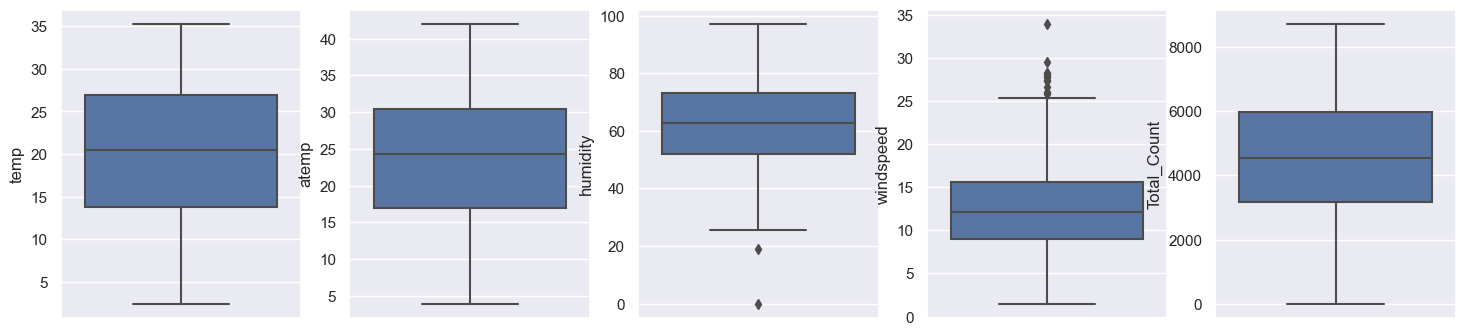

In [9]:
# For the non categorical data the plots can help us to visualize the data sanity
cols = ['temp', 'atemp', 'humidity', 'windspeed', 'Total_Count']
plt.figure(figsize=(18,4))

i = 1
for col in cols:
    plt.subplot(1,5,i)
    sns.boxplot(y=col, data= df)
    i+=1

The plots above gives the understanding of the data in a better way. The values for all the variables are in normal range and no abnormality is observed. There are no outliners

There are quite a few insight which can be derived from the data. This insight will help to understand the data better. We can visualize the relation between the target variable and the independent variables to see which factors affects the total count to what extent

In [10]:
# bar chart gives a easy way to see the trend of target variable w.r.t. independent variables.In addition we can try to 
# find out the trend for the target variable in corelation with  multiple variables

def plot_cat_columns(column):
    plt.figure(figsize = (12,6))
    plt.subplot(1,2,1)
    sns.barplot(x=column,y='Total_Count',data = df)
    plt.subplot(1,2,2)
    sns.barplot(x=column,y='Total_Count',data=df, hue='yr',palette='Set1')
    plt.legend(labels=['2018', '2019'])
    plt.show()

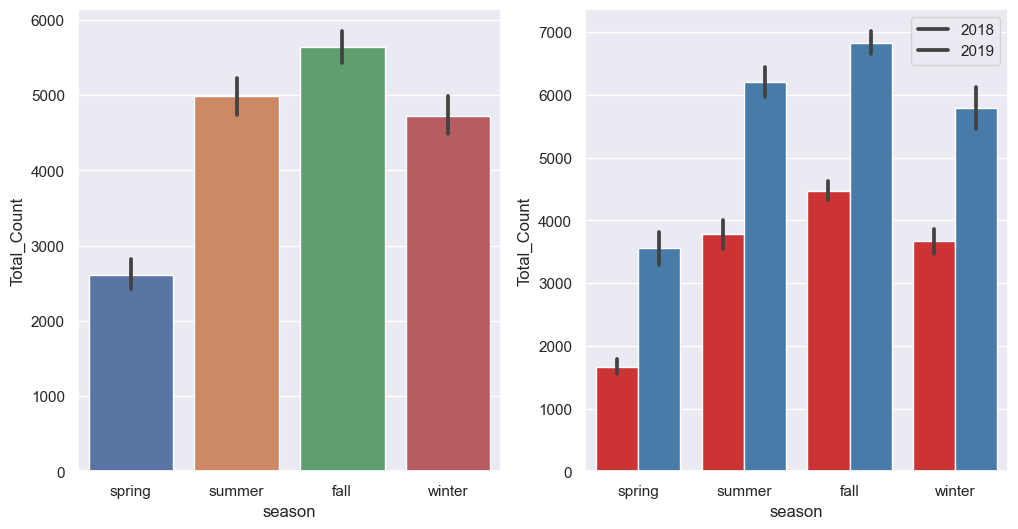

In [11]:
plot_cat_columns('season')

There is a seasonal variation in demand peaking out in fall
There is a year on year growth for total number of users

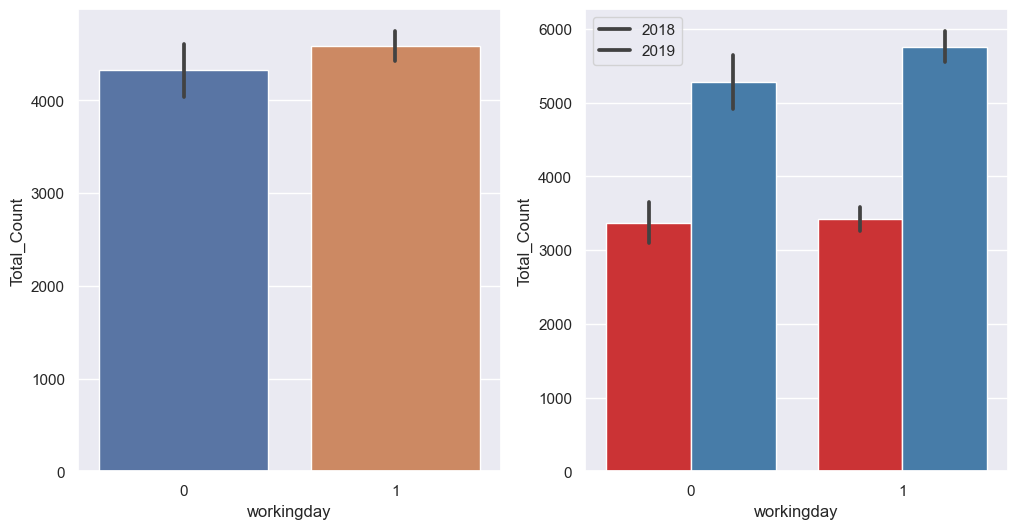

In [12]:
plot_cat_columns('workingday')

There is a slight variation based on wheter the day is aworking day or not.
The year on year growth is visible here also

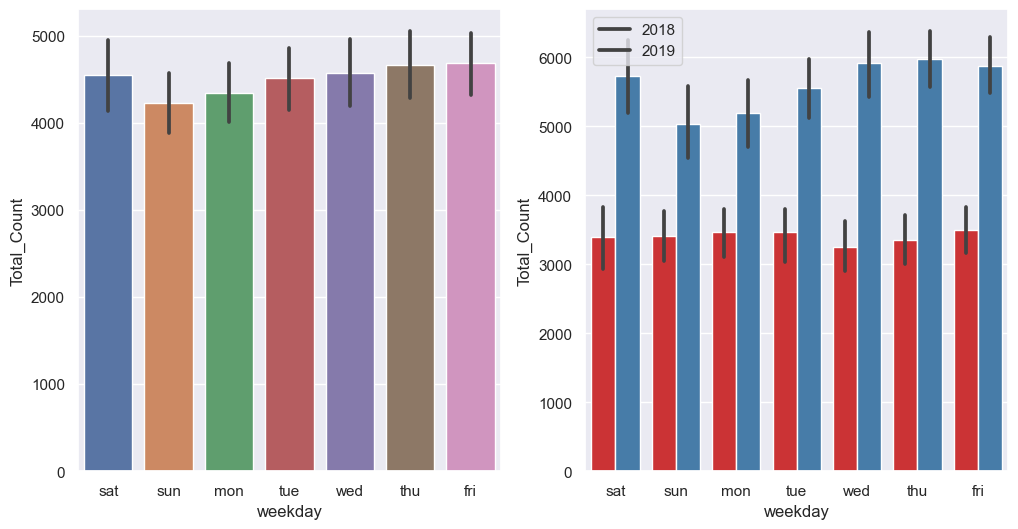

In [13]:
plot_cat_columns('weekday')

The demand is fairly steady throughout the week, slightly being higher on Saturday.

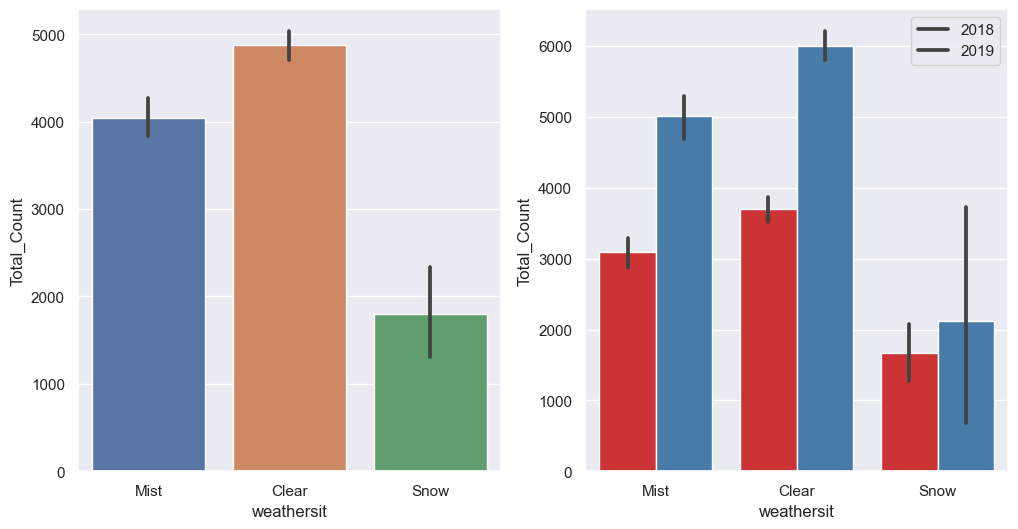

In [14]:
plot_cat_columns('weathersit')

Weather has an impact on demand. As obvious the demand is hight when weather is clear. There are no takes on a rainy day

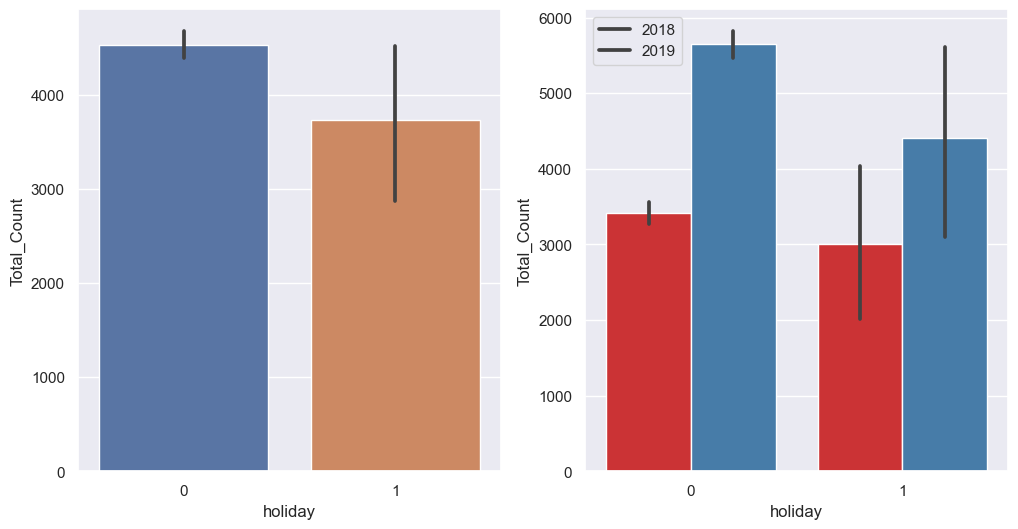

In [15]:
plot_cat_columns('holiday')

There is a decrease in demand on holidays

By analyzing the variables there is hight probability that some of the variables may be strongly corealted. A first cut anlysis on the vriable shows that the variables which are related to weather have a high chance of corelation

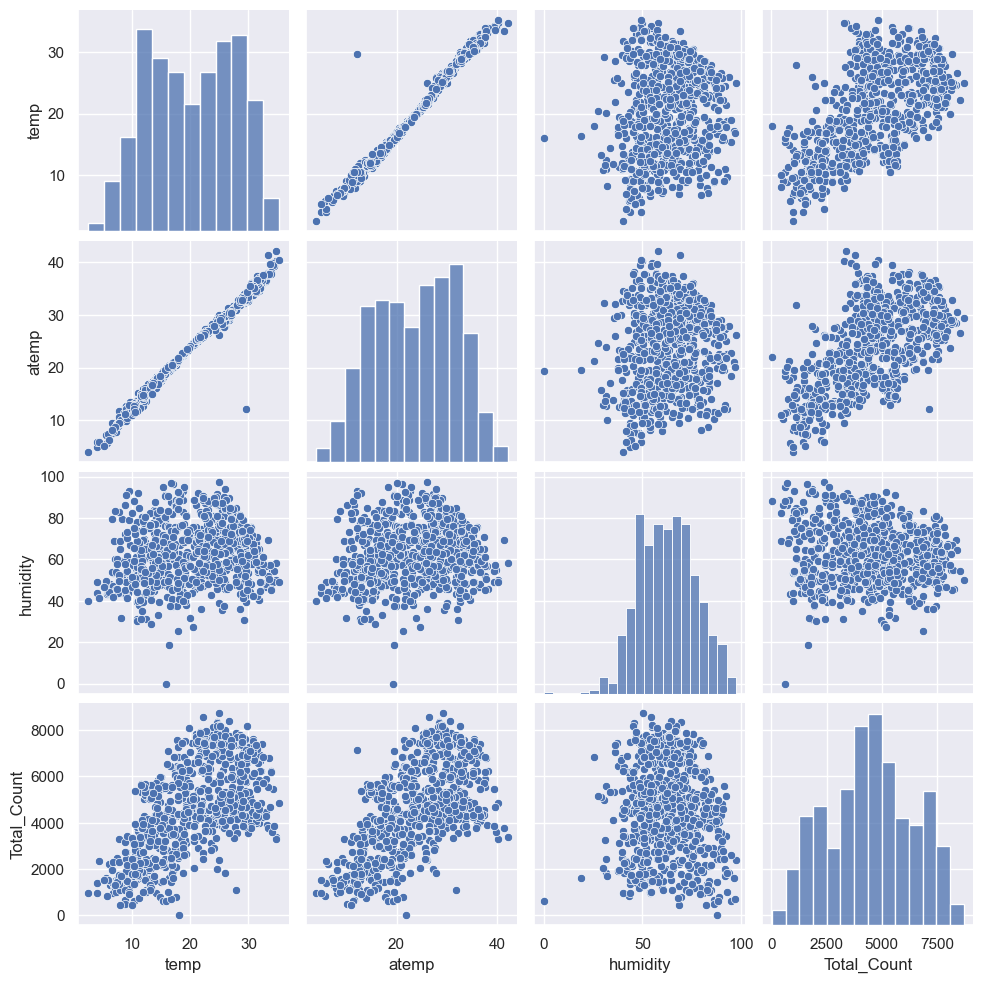

In [16]:
sns.pairplot(data=df,vars=['temp','atemp','humidity','Total_Count'])
plt.show()

The corelation between the independent variables has to be analysized to avoid any complication due to multicolienarity.

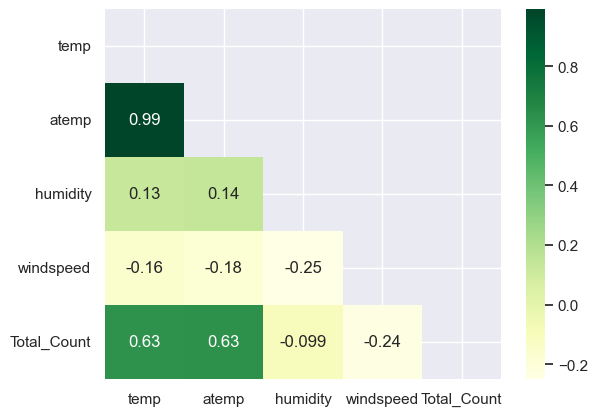

In [17]:
#checking continous variables relationship with each other
matrix = np.triu(df[['temp','atemp','humidity','windspeed','Total_Count']].corr())
sns.heatmap(df[['temp','atemp','humidity','windspeed','Total_Count']].corr(),cmap ='YlGn',annot = True, mask=matrix)
plt.show()

As anticipated temp and atemp have a strong corelation as atemp is derived from temp. One of the variable will be droped going based on VIF. 

Step3: Data Preparation

For the Categorical data with more than 2 values dummy variables are to be created as next step

In [18]:
# Creating the dummy variables

df = pd.get_dummies(df,columns = ['mnth','weekday','weathersit','season'],drop_first = True)
df.head()

,yr,holiday,workingday,temp,atemp,humidity,windspeed,Total_Count,mnth_aug,mnth_dec,...,weekday_sat,weekday_sun,weekday_thu,weekday_tue,weekday_wed,weathersit_Mist,weathersit_Snow,season_spring,season_summer,season_winter
0,0,0,0,14.110847,18.18125,80.5833,10.749882,985,0,0,...,1,0,0,0,0,1,0,1,0,0
1,0,0,0,14.902598,17.68695,69.6087,16.652113,801,0,0,...,0,1,0,0,0,1,0,1,0,0
2,0,0,1,8.050924,9.47025,43.7273,16.636703,1349,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,1,8.200000,10.60610,59.0435,10.739832,1562,0,0,...,0,0,0,1,0,0,0,1,0,0
4,0,0,1,9.305237,11.46350,43.6957,12.522300,1600,0,0,...,0,0,0,0,1,0,0,1,0,0


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 30 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   yr               730 non-null    int64  
 1   holiday          730 non-null    int64  
 2   workingday       730 non-null    int64  
 3   temp             730 non-null    float64
 4   atemp            730 non-null    float64
 5   humidity         730 non-null    float64
 6   windspeed        730 non-null    float64
 7   Total_Count      730 non-null    int64  
 8   mnth_aug         730 non-null    uint8  
 9   mnth_dec         730 non-null    uint8  
 10  mnth_feb         730 non-null    uint8  
 11  mnth_jan         730 non-null    uint8  
 12  mnth_july        730 non-null    uint8  
 13  mnth_june        730 non-null    uint8  
 14  mnth_mar         730 non-null    uint8  
 15  mnth_may         730 non-null    uint8  
 16  mnth_nov         730 non-null    uint8  
 17  mnth_oct        

Step4: Creating Train and Test data 

In [20]:
# splitting the dataframe into Train and Test using 70:30 ratio

np.random.seed(0)
df_train, df_test = train_test_split(df, train_size = 0.7, random_state = 100)

In [21]:
scaler = MinMaxScaler()

In [22]:
df_train.head()

,yr,holiday,workingday,temp,atemp,humidity,windspeed,Total_Count,mnth_aug,mnth_dec,...,weekday_sat,weekday_sun,weekday_thu,weekday_tue,weekday_wed,weathersit_Mist,weathersit_Snow,season_spring,season_summer,season_winter
576,1,0,1,29.246653,33.1448,70.4167,11.083475,7216,0,0,...,0,0,0,1,0,0,0,0,0,0
426,1,0,0,16.980847,20.6746,62.1250,10.792293,4066,0,0,...,1,0,0,0,0,1,0,1,0,0
728,1,0,0,10.489153,11.5850,48.3333,23.500518,1796,0,1,...,0,1,0,0,0,0,0,1,0,0
482,1,0,0,15.443347,18.8752,48.9583,8.708325,4220,0,0,...,1,0,0,0,0,1,0,0,1,0
111,0,0,1,13.803347,16.0977,72.9583,14.707907,1683,0,0,...,0,0,0,0,0,1,0,0,1,0


In [23]:
# Apply scaler() to all the columns except the 'yes-no' and 'dummy' variables

num_vars = ['temp','atemp','humidity','windspeed','Total_Count']
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])

In [24]:
# verifying the head after appying scaling.

df_train.head()

,yr,holiday,workingday,temp,atemp,humidity,windspeed,Total_Count,mnth_aug,mnth_dec,...,weekday_sat,weekday_sun,weekday_thu,weekday_tue,weekday_wed,weathersit_Mist,weathersit_Snow,season_spring,season_summer,season_winter
576,1,0,1,0.815169,0.766351,0.725633,0.264686,0.827658,0,0,...,0,0,0,1,0,0,0,0,0,0
426,1,0,0,0.442393,0.438975,0.640189,0.255342,0.465255,0,0,...,1,0,0,0,0,1,0,1,0,0
728,1,0,0,0.245101,0.200348,0.498067,0.663106,0.204096,0,1,...,0,1,0,0,0,0,0,1,0,0
482,1,0,0,0.395666,0.391735,0.504508,0.188475,0.482973,0,0,...,1,0,0,0,0,1,0,0,1,0
111,0,0,1,0.345824,0.318819,0.751824,0.380981,0.191095,0,0,...,0,0,0,0,0,1,0,0,1,0


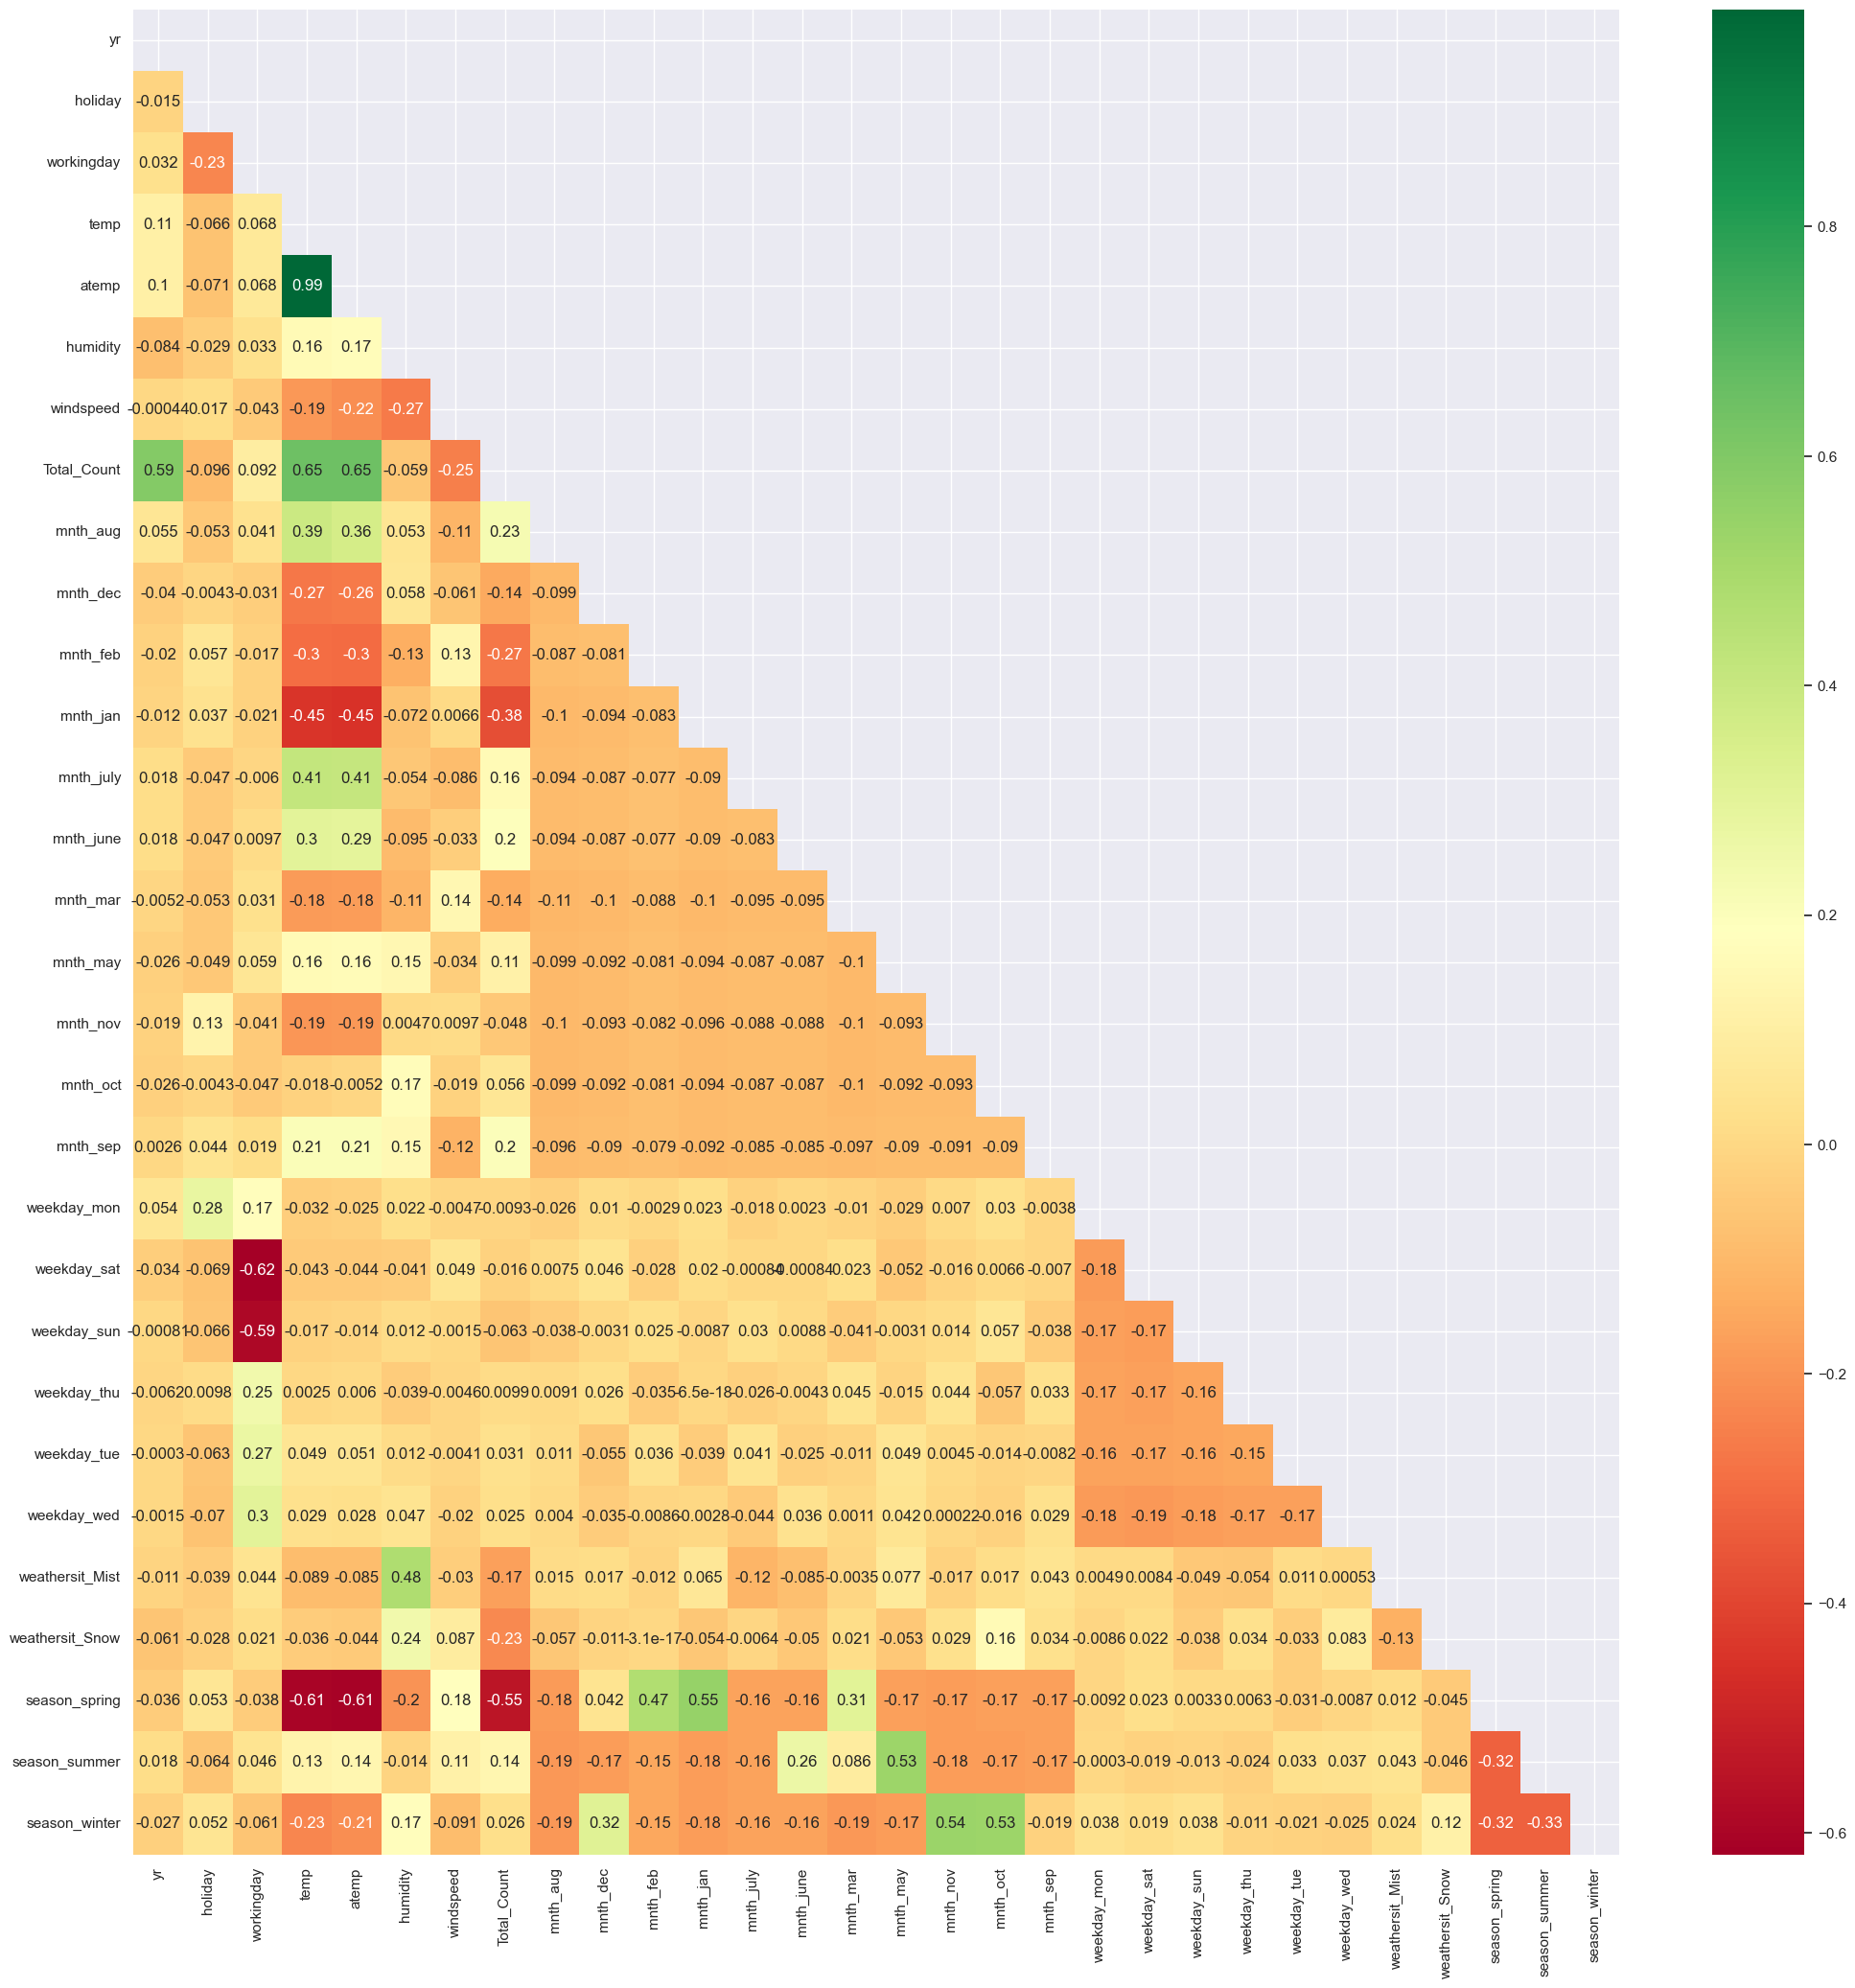

In [25]:
# check the correlation coefficients to see which variables are highly correlated

plt.figure(figsize = (25,25))
matrix = np.triu(df_train.corr())
sns.heatmap(df_train.corr(), annot = True, cmap="RdYlGn", mask=matrix)
plt.show()

Step5: Building Linear Regression Model

In [26]:
# Building the Linear Model

y_train = df_train.pop('Total_Count')
X_train = df_train

In [27]:
df_train.head()

,yr,holiday,workingday,temp,atemp,humidity,windspeed,mnth_aug,mnth_dec,mnth_feb,...,weekday_sat,weekday_sun,weekday_thu,weekday_tue,weekday_wed,weathersit_Mist,weathersit_Snow,season_spring,season_summer,season_winter
576,1,0,1,0.815169,0.766351,0.725633,0.264686,0,0,0,...,0,0,0,1,0,0,0,0,0,0
426,1,0,0,0.442393,0.438975,0.640189,0.255342,0,0,0,...,1,0,0,0,0,1,0,1,0,0
728,1,0,0,0.245101,0.200348,0.498067,0.663106,0,1,0,...,0,1,0,0,0,0,0,1,0,0
482,1,0,0,0.395666,0.391735,0.504508,0.188475,0,0,0,...,1,0,0,0,0,1,0,0,1,0
111,0,0,1,0.345824,0.318819,0.751824,0.380981,0,0,0,...,0,0,0,0,0,1,0,0,1,0


In [28]:
# Recursive feature elimination 

lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(estimator=lm, n_features_to_select=15)
rfe = rfe.fit(X_train, y_train)

In [29]:
#List of variables selected in top 15 list

list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', True, 1),
 ('temp', True, 1),
 ('atemp', False, 5),
 ('humidity', True, 1),
 ('windspeed', True, 1),
 ('mnth_aug', False, 7),
 ('mnth_dec', False, 3),
 ('mnth_feb', False, 4),
 ('mnth_jan', True, 1),
 ('mnth_july', True, 1),
 ('mnth_june', False, 14),
 ('mnth_mar', False, 15),
 ('mnth_may', False, 6),
 ('mnth_nov', False, 2),
 ('mnth_oct', False, 13),
 ('mnth_sep', True, 1),
 ('weekday_mon', False, 9),
 ('weekday_sat', True, 1),
 ('weekday_sun', False, 8),
 ('weekday_thu', False, 11),
 ('weekday_tue', False, 10),
 ('weekday_wed', False, 12),
 ('weathersit_Mist', True, 1),
 ('weathersit_Snow', True, 1),
 ('season_spring', True, 1),
 ('season_summer', True, 1),
 ('season_winter', True, 1)]

In [30]:
# selecting the selected variable via RFE

col = X_train.columns[rfe.support_]
print(col)

Index(['yr', 'holiday', 'workingday', 'temp', 'humidity', 'windspeed',
       'mnth_jan', 'mnth_july', 'mnth_sep', 'weekday_sat', 'weathersit_Mist',
       'weathersit_Snow', 'season_spring', 'season_summer', 'season_winter'],
      dtype='object')


In [31]:
# checking which columns has been rejected

X_train.columns[~rfe.support_]

Index(['atemp', 'mnth_aug', 'mnth_dec', 'mnth_feb', 'mnth_june', 'mnth_mar',
       'mnth_may', 'mnth_nov', 'mnth_oct', 'weekday_mon', 'weekday_sun',
       'weekday_thu', 'weekday_tue', 'weekday_wed'],
      dtype='object')

In [32]:
def calculateVIF(df):
    vif = pd.DataFrame()
    vif['Features'] = df.columns
    vif['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return vif 

In [33]:
# Building dataframe with RFE selected variables

X_train_rfe = X_train[col]

In [34]:
# calculate VIF of training set

calculateVIF(X_train_rfe)

,Features,VIF
4,humidity,29.37
3,temp,17.78
2,workingday,5.31
5,windspeed,4.73
12,season_spring,4.53
14,season_winter,3.46
13,season_summer,2.85
10,weathersit_Mist,2.29
0,yr,2.09
9,weekday_sat,1.98


Humidity has highest VIF and the VIF for other parameters are also not in good range

In [35]:
X_train_lm_1 = sm.add_constant(X_train_rfe).astype(int)
X_train_lm_1.head()

,const,yr,holiday,workingday,temp,humidity,windspeed,mnth_jan,mnth_july,mnth_sep,weekday_sat,weathersit_Mist,weathersit_Snow,season_spring,season_summer,season_winter
576,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0
426,1,1,0,0,0,0,0,0,0,0,1,1,0,1,0,0
728,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
482,1,1,0,0,0,0,0,0,0,0,1,1,0,0,1,0
111,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0


In [36]:
# Building 1st linear regression model
lr_1 = sm.OLS(y_train,X_train_lm_1).fit()
print(lr_1.summary())

                            OLS Regression Results                            
Dep. Variable:            Total_Count   R-squared:                       0.762
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                     122.5
Date:                Sun, 01 Dec 2024   Prob (F-statistic):          1.83e-145
Time:                        22:08:53   Log-Likelihood:                 405.48
No. Observations:                 510   AIC:                            -783.0
Df Residuals:                     496   BIC:                            -723.7
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.4936      0.019     

In [37]:
# As humidity shows highest VIF value hence it can drop it
X_train_new = X_train_rfe.drop(['humidity'], axis = 1)

# Run the function to calculate VIF for the new model
calculateVIF(X_train_new)

,Features,VIF
3,temp,7.07
2,workingday,5.24
4,windspeed,4.68
11,season_spring,3.07
12,season_summer,2.34
0,yr,2.08
13,season_winter,1.98
8,weekday_sat,1.97
5,mnth_jan,1.62
6,mnth_july,1.59


In [38]:
# Building 2nd linear regression model

X_train_lm_2 = sm.add_constant(X_train_new)
lr_2 = sm.OLS(y_train,X_train_lm_2).fit()
print(lr_2.summary())

                            OLS Regression Results                            
Dep. Variable:            Total_Count   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     189.6
Date:                Sun, 01 Dec 2024   Prob (F-statistic):          1.60e-188
Time:                        22:08:53   Log-Likelihood:                 510.75
No. Observations:                 510   AIC:                            -991.5
Df Residuals:                     495   BIC:                            -928.0
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1737      0.031     

Dropping humidity improved the VIF and R-Squared improved 

In [39]:
# We can drop Workingday variable as it has high VIF
X_train_new = X_train_new.drop(['workingday'], axis = 1)

# Run the function to calculate VIF for the new model
calculateVIF(X_train_new)

,Features,VIF
2,temp,5.16
3,windspeed,4.64
10,season_spring,2.76
11,season_summer,2.24
0,yr,2.07
12,season_winter,1.80
4,mnth_jan,1.61
5,mnth_july,1.59
8,weathersit_Mist,1.56
6,mnth_sep,1.34


In [40]:
# Building 3rd linear regression model

X_train_lm_3 = sm.add_constant(X_train_new)
lr_3 = sm.OLS(y_train,X_train_lm_3).fit()
print(lr_3.summary())

                            OLS Regression Results                            
Dep. Variable:            Total_Count   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     197.1
Date:                Sun, 01 Dec 2024   Prob (F-statistic):          2.48e-186
Time:                        22:08:53   Log-Likelihood:                 502.77
No. Observations:                 510   AIC:                            -977.5
Df Residuals:                     496   BIC:                            -918.3
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.2120      0.030     

VIF is improving for the remaining independent variables and R-Squared is not impacted much by droping variable

In [41]:
# We can drop windspeed variable as it has high VIF
X_train_new = X_train_new.drop(['windspeed'], axis = 1)

# Run the function to calculate VIF for the new model
calculateVIF(X_train_new)

,Features,VIF
2,temp,4.34
0,yr,2.07
9,season_spring,2.02
10,season_summer,1.95
3,mnth_jan,1.60
4,mnth_july,1.59
11,season_winter,1.59
7,weathersit_Mist,1.56
5,mnth_sep,1.34
6,weekday_sat,1.19


In [42]:
# Building 4th linear regression model

X_train_lm_4 = sm.add_constant(X_train_new)
lr_4 = sm.OLS(y_train,X_train_lm_4).fit()
print(lr_4.summary())

                            OLS Regression Results                            
Dep. Variable:            Total_Count   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                     195.5
Date:                Sun, 01 Dec 2024   Prob (F-statistic):          2.04e-179
Time:                        22:10:01   Log-Likelihood:                 483.58
No. Observations:                 510   AIC:                            -941.2
Df Residuals:                     497   BIC:                            -886.1
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1552      0.030     

All VIFs are below 5 now & R-Squared is still Decent. Let's try to improve the model a bit more 

In [43]:
# We can drop mnth_jan variable as it has high p-value
X_train_new = X_train_new.drop(['mnth_jan'], axis = 1)

# Run the function to calculate VIF for the new model
calculateVIF(X_train_new)

,Features,VIF
2,temp,4.27
0,yr,2.07
9,season_summer,1.94
10,season_winter,1.59
3,mnth_july,1.58
6,weathersit_Mist,1.55
8,season_spring,1.43
4,mnth_sep,1.34
5,weekday_sat,1.19
7,weathersit_Snow,1.07


In [44]:
# Building 5th linear regression model

X_train_lm_5 = sm.add_constant(X_train_new)
lr_5 = sm.OLS(y_train,X_train_lm_5).fit()
print(lr_5.summary())

                            OLS Regression Results                            
Dep. Variable:            Total_Count   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                     212.8
Date:                Sun, 01 Dec 2024   Prob (F-statistic):          3.21e-180
Time:                        22:10:24   Log-Likelihood:                 482.70
No. Observations:                 510   AIC:                            -941.4
Df Residuals:                     498   BIC:                            -890.6
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1466      0.029     

In [45]:
# We can drop weekday_sat variable as it has high p-value
X_train_new = X_train_new.drop(['weekday_sat'], axis = 1)

# Run the function to calculate VIF for the new model
calculateVIF(X_train_new)

,Features,VIF
2,temp,4.22
0,yr,2.06
8,season_summer,1.94
3,mnth_july,1.58
9,season_winter,1.57
5,weathersit_Mist,1.55
7,season_spring,1.40
4,mnth_sep,1.34
6,weathersit_Snow,1.07
1,holiday,1.04


In [46]:
# Building 6th linear regression model

X_train_lm_6 = sm.add_constant(X_train_new)
lr_6 = sm.OLS(y_train,X_train_lm_6).fit()
print(lr_6.summary())

                            OLS Regression Results                            
Dep. Variable:            Total_Count   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     233.3
Date:                Sun, 01 Dec 2024   Prob (F-statistic):          5.71e-181
Time:                        22:11:02   Log-Likelihood:                 481.64
No. Observations:                 510   AIC:                            -941.3
Df Residuals:                     499   BIC:                            -894.7
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1501      0.029     

In [47]:
# We can drop season_summer variable as it has high p-value
X_train_new = X_train_new.drop(['season_summer'], axis = 1)

# Run the function to calculate VIF for the new model
calculateVIF(X_train_new)

,Features,VIF
2,temp,2.99
0,yr,2.05
5,weathersit_Mist,1.51
3,mnth_july,1.33
8,season_winter,1.33
7,season_spring,1.25
4,mnth_sep,1.19
6,weathersit_Snow,1.06
1,holiday,1.04


In [48]:
# Building 7th linear regression model

X_train_lm_7 = sm.add_constant(X_train_new)
lr_7 = sm.OLS(y_train,X_train_lm_7).fit()
print(lr_7.summary())

                            OLS Regression Results                            
Dep. Variable:            Total_Count   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     256.3
Date:                Sun, 01 Dec 2024   Prob (F-statistic):          5.25e-181
Time:                        22:11:11   Log-Likelihood:                 478.85
No. Observations:                 510   AIC:                            -937.7
Df Residuals:                     500   BIC:                            -895.4
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1952      0.022     

All VIFs below 3 , P Values are zero and R-squared is above 8. R-Squared has not detoriated by removal of variables.

In [49]:
# Checking the parameters and their coefficient values
lr_7.params

const              0.195172
yr                 0.233180
holiday           -0.100571
temp               0.469496
mnth_july         -0.068985
mnth_sep           0.065396
weathersit_Mist   -0.078124
weathersit_Snow   -0.299283
season_spring     -0.112165
season_winter      0.053423
dtype: float64

In [50]:
X_train_lm_7

,const,yr,holiday,temp,mnth_july,mnth_sep,weathersit_Mist,weathersit_Snow,season_spring,season_winter
576,1.0,1,0,0.815169,1,0,0,0,0,0
426,1.0,1,0,0.442393,0,0,1,0,1,0
728,1.0,1,0,0.245101,0,0,0,0,1,0
482,1.0,1,0,0.395666,0,0,1,0,0,0
111,1.0,0,0,0.345824,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
578,1.0,1,0,0.863973,0,0,0,0,0,0
53,1.0,0,0,0.202618,0,0,0,0,1,0
350,1.0,0,0,0.248216,0,0,1,0,0,1
79,1.0,0,0,0.462664,0,0,1,0,0,0


In [51]:
y_train_pred = lr_7.predict(X_train_lm_7) 

Step 6: Validating Assumptions of Linear Regression

Linearity

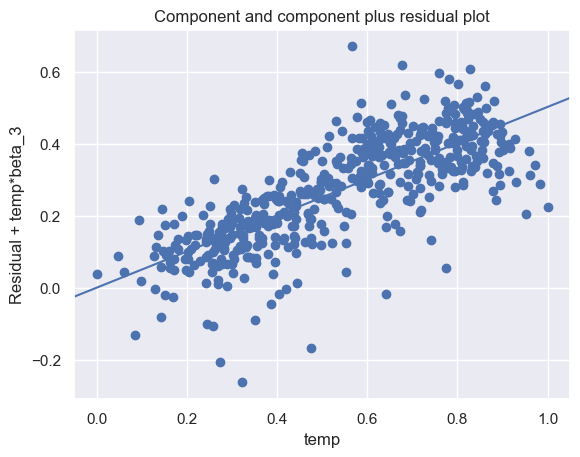

In [52]:
# Linear relationship validation using CCPR plot
# Component and component plus residual plot

sm.graphics.plot_ccpr(lr_6, 'temp')
plt.show()


The Durbin-Watson value is 2.021 which indicates a good linearity

Normality of error terms

C:\Users\Saurabh\AppData\Local\Temp\ipykernel_8172\3536760436.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((y_train - y_train_pred), bins = 20)


Text(0.5, 0, 'Errors')

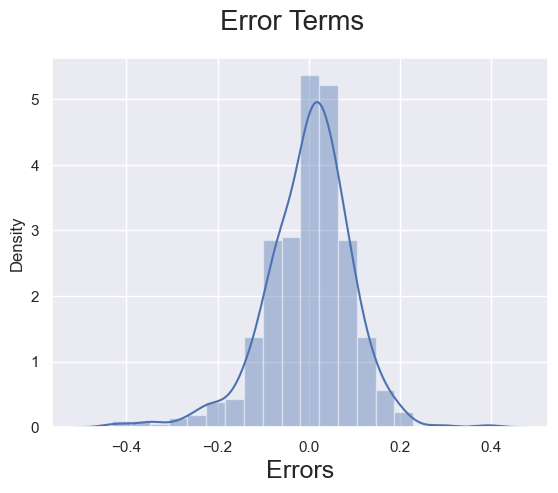

In [53]:
# Plot the histogram of the error terms

fig = plt.figure()
sns.distplot((y_train - y_train_pred), bins = 20)
fig.suptitle('Error Terms', fontsize = 20) 
plt.xlabel('Errors', fontsize = 18)

The errors have a Normal Distribution

Multicolinearity

In [54]:
calculateVIF(X_train_new)

,Features,VIF
2,temp,2.99
0,yr,2.05
5,weathersit_Mist,1.51
3,mnth_july,1.33
8,season_winter,1.33
7,season_spring,1.25
4,mnth_sep,1.19
6,weathersit_Snow,1.06
1,holiday,1.04


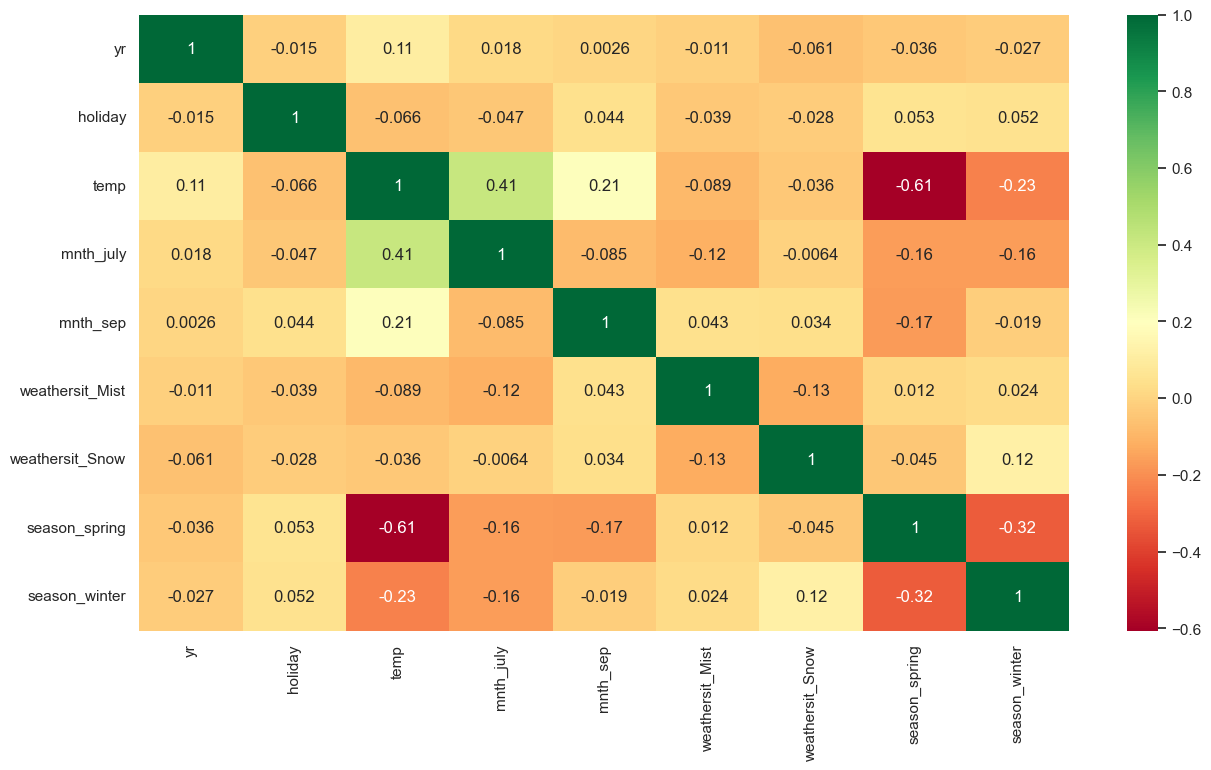

In [55]:
plt.figure(figsize=(15,8))
sns.heatmap(X_train_new.corr(),annot = True, cmap="RdYlGn")
plt.show()

VIF for all the variables is below 3 & heatmap does not show a corelation

Homoscedasticity

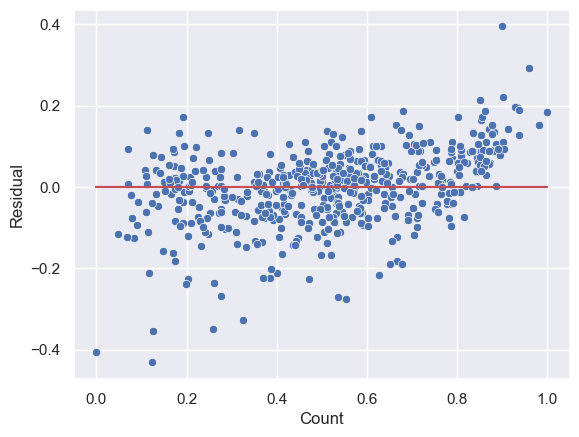

In [56]:
y_train_pred = lr_7.predict(X_train_lm_7)
residual = y_train - y_train_pred
sns.scatterplot(x = y_train,y = residual)
plt.plot(y_train,(y_train - y_train), '-r')
plt.xlabel('Count')
plt.ylabel('Residual')
plt.show()

Residuals are well distributed

Making Prediction using developed model

In [57]:
# Applying scaling on the test dataset

num_vars = ['temp', 'atemp', 'humidity', 'windspeed','Total_Count']
df_test[num_vars] = scaler.transform(df_test[num_vars])
df_test.head()

,yr,holiday,workingday,temp,atemp,humidity,windspeed,Total_Count,mnth_aug,mnth_dec,...,weekday_sat,weekday_sun,weekday_thu,weekday_tue,weekday_wed,weathersit_Mist,weathersit_Snow,season_spring,season_summer,season_winter
184,0,1,0,0.831783,0.769660,0.657364,0.084219,0.692706,0,0,...,0,0,0,0,0,1,0,0,0,0
535,1,0,1,0.901354,0.842587,0.610133,0.153728,0.712034,0,0,...,0,0,0,0,1,0,0,0,1,0
299,0,0,1,0.511964,0.496145,0.837699,0.334206,0.303382,0,0,...,0,0,1,0,0,1,0,0,0,1
221,0,0,1,0.881625,0.795343,0.437098,0.339570,0.547400,1,0,...,0,0,0,0,1,0,0,0,0,0
152,0,0,1,0.817246,0.741471,0.314298,0.537414,0.569029,0,0,...,0,0,1,0,0,0,0,0,1,0


In [58]:
df_test.describe()

,yr,holiday,workingday,temp,atemp,humidity,windspeed,Total_Count,mnth_aug,mnth_dec,...,weekday_sat,weekday_sun,weekday_thu,weekday_tue,weekday_wed,weathersit_Mist,weathersit_Snow,season_spring,season_summer,season_winter
count,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,...,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000
mean,0.481818,0.036364,0.700000,0.558718,0.532847,0.638221,0.313293,0.522154,0.059091,0.086364,...,0.118182,0.145455,0.163636,0.168182,0.100000,0.318182,0.027273,0.254545,0.263636,0.236364
std,0.500809,0.187620,0.459303,0.233187,0.217401,0.148694,0.159584,0.219163,0.236333,0.281541,...,0.323559,0.353363,0.370789,0.374881,0.300684,0.466833,0.163248,0.436599,0.441609,0.425817
min,0.000000,0.000000,0.000000,0.046591,0.025950,0.261915,-0.042808,0.048205,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.355429,0.344870,0.529197,0.198843,0.378595,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.558172,0.544652,0.625590,0.300126,0.524678,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.755981,0.713308,0.743798,0.402718,0.677750,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,0.984424,0.980934,1.002146,0.807474,0.963300,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [59]:
y_test = df_test.pop('Total_Count')
X_test = df_test

In [60]:
col1 = X_train_new.columns

X_test = X_test[col1]

# Adding constant variable to test dataframe
X_test_lm_7 = sm.add_constant(X_test)
X_test_lm_7 .head()

,const,yr,holiday,temp,mnth_july,mnth_sep,weathersit_Mist,weathersit_Snow,season_spring,season_winter
184,1.0,0,1,0.831783,1,0,1,0,0,0
535,1.0,1,0,0.901354,0,0,0,0,0,0
299,1.0,0,0,0.511964,0,0,1,0,0,1
221,1.0,0,0,0.881625,0,0,0,0,0,0
152,1.0,0,0,0.817246,0,0,0,0,0,0


In [61]:
y_pred = lr_7.predict(X_test_lm_7)

In [62]:
r2 = r2_score(y_test, y_pred)
round(r2,4)

0.8096

Model Evaluation

In [63]:
# Calculating Adjusted-R^2 value for the test dataset

adjusted_r2 = round(1-(1-r2)*(X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1),4)
print(adjusted_r2)

0.8014


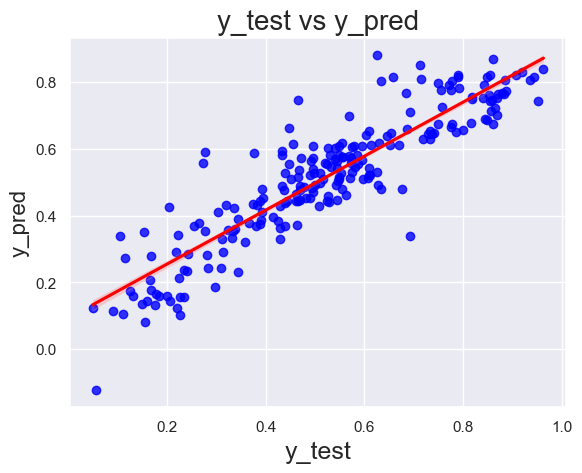

In [64]:
# Visualizing the fit on the test data
# plotting a Regression plot

plt.figure()
sns.regplot(x=y_test, y=y_pred, ci=68, fit_reg=True,scatter_kws={"color": "blue"}, line_kws={"color": "red"})
plt.title('y_test vs y_pred', fontsize=20)
plt.xlabel('y_test', fontsize=18)
plt.ylabel('y_pred', fontsize=16)
plt.show()

Comparision between Training and Testing dataset:
- Train dataset R^2          : 0.822
- Test dataset R^2           : 0.8096
- Train dataset Adjusted R^2 : 0.819    
- Test dataset Adjusted R^2  : 0.8014
The major factor affecting the demand for Bike rentals are temp, yr , weathersit_Mist , mnth_july , season_winter , season_spring, mnth_sep, weathersit_Snow, holiday